### Necessary Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
import re
import nltk
import random
import string

In [3]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [4]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [5]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from warnings import filterwarnings
filterwarnings("ignore")

### Performing EDA

In [8]:
df = pd.read_csv('customer_reviews.csv', index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [10]:
# summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Clothing ID,23486.0,918.118709,203.298980,0.0,861.0,936.0,1078.0,1205.0
Age,23486.0,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,23486.0,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Recommended IND,23486.0,0.822362,0.382216,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,23486.0,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0


In [11]:
# variables
num = ['Age','Positive Feedback Count']
cat = ['Rating','Recommended IND']
obj = ['Division Name','Department Name','Class Name']
txt = ['Title','Review Text']

### Numerical Fields

In [12]:
# distribution and boxplots
def distribution(x):
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    sns.histplot(df[x], bins=20, ax=ax[0])
    ax[0].set_title('Distribution of {}'.format(x), fontsize=15)
    sns.boxplot(df[x], color='orange', ax=ax[1])
    ax[1].set_title('Boxplot of {}'.format(x), fontsize=15)
    plt.tight_layout()

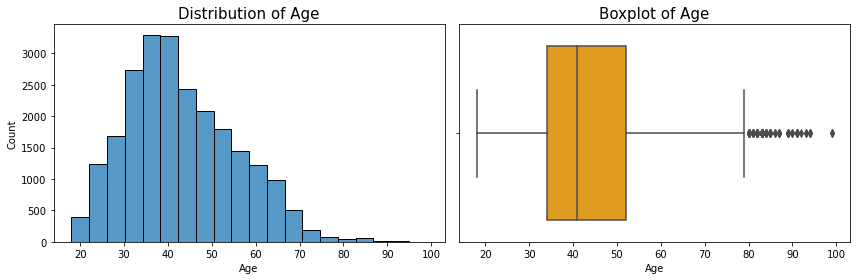

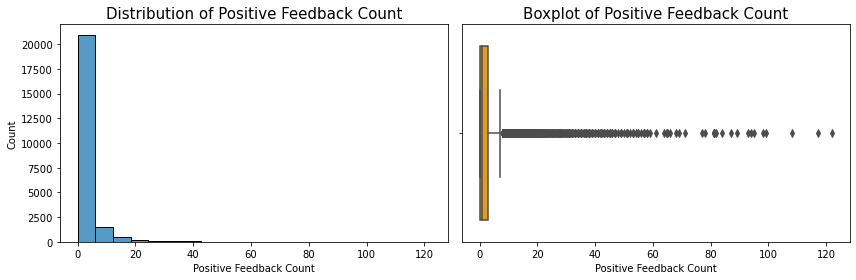

In [13]:
# distributions
for i in num:
    distribution(i)

**Positive feedback counts are highly skewed**

### Categorical Fields

In [14]:
# static method for plot
def count(x):
    plt.figure(figsize=(12,7))
    sns.countplot(y=df[x])
    plt.title('{} Counts'.format(x), fontsize=15)
    plt.show()

In [15]:
for i in cat:
    print("No.of.categories: {}".format(df[i].nunique()))
    print("")
    print(df[i].value_counts())
    print("---------------------------------")
    print("")

No.of.categories: 5

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64
---------------------------------

No.of.categories: 2

1    19314
0     4172
Name: Recommended IND, dtype: int64
---------------------------------



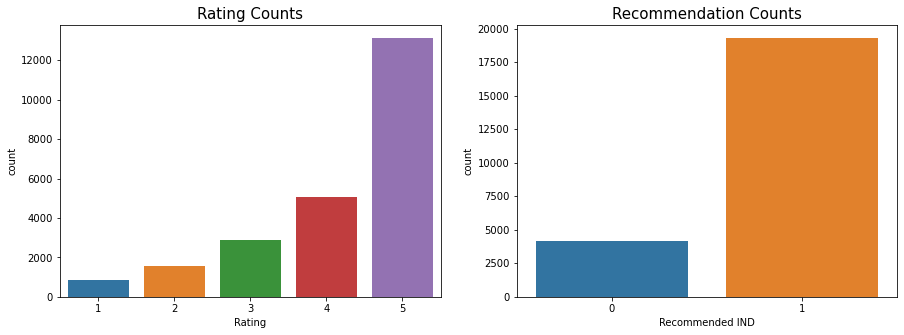

In [16]:
# plots
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(df['Rating'], ax=ax[0])
ax[0].set_title('Rating Counts', fontsize=15)
sns.countplot(df['Recommended IND'], ax=ax[1])
ax[1].set_title('Recommendation Counts', fontsize=15)
plt.show()

In [17]:
for i in obj:
    print("No.of.categories: {}".format(df[i].nunique()))
    print("")
    print(df[i].value_counts())
    print("---------------------------------")
    print("")

No.of.categories: 3

General           13850
General Petite     8120
Initmates          1502
Name: Division Name, dtype: int64
---------------------------------

No.of.categories: 6

Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: Department Name, dtype: int64
---------------------------------

No.of.categories: 20

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: Class Name, dtype: int64
---------------------------------



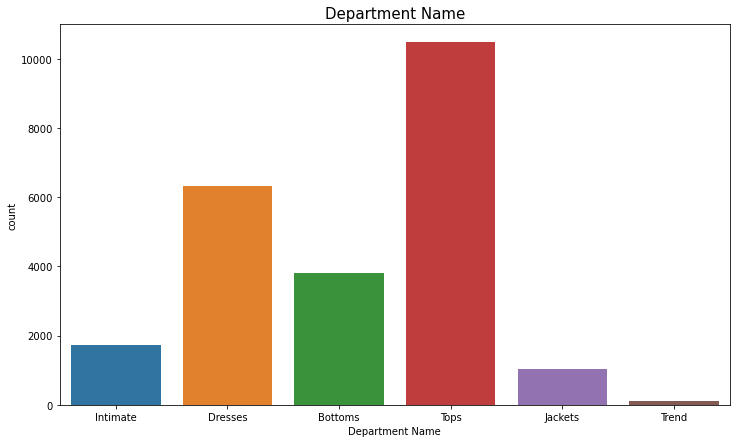

In [18]:
# department name variable
plt.figure(figsize=(12,7))
sns.countplot(df['Department Name'])
plt.title('Department Name', fontsize=15)
plt.show()

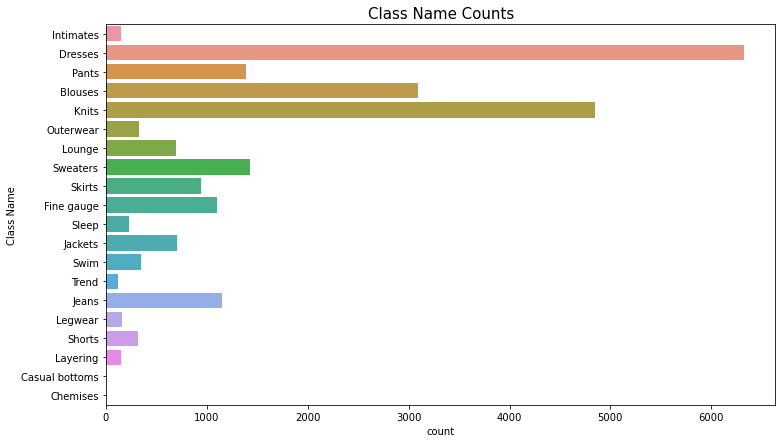

In [19]:
# department name variable
plt.figure(figsize=(12,7))
sns.countplot(y=df['Class Name'])
plt.title('Class Name Counts', fontsize=15)
plt.show()

**More reviews were given on product sub-category 'Tops' under the category 'Dresses' and more 5 star rating were given by the customers. So, we can expect more positive reviews from the customers.**

### NLP Modelling

### Approach-01

Using NLTK's Naive Bayes Classifier.

In [20]:
# getting the necessary data

data = df[['Review Text','Rating']]
data.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


In [21]:
data.isnull().sum()

Review Text    845
Rating           0
dtype: int64

In [22]:
# here revies are missing, they are the primary field in nlp
data.dropna(inplace=True)

In [23]:
data.isnull().sum()

Review Text    0
Rating         0
dtype: int64

In [24]:
# resetting the index
data.reset_index(drop=True, inplace=True)

In [25]:
# renaming the columns
data.columns = ['review','rating']

In [26]:
data['rating'].describe()

count    22641.000000
mean         4.183561
std          1.115762
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [27]:
# checking the proportion of rating 3 and below
len(data[data['rating']<=3])/len(data)

0.22936266065986485

In [28]:
# let's create the label field
sentiment = []

for i in range(0,len(data)):
    if data['rating'][i] > 3:
        sentiment.append('positive')
    else:
        sentiment.append('negative')

In [29]:
# attaching it with the data
data['label'] = sentiment

In [30]:
# removing the rating column
data.drop('rating', axis=1, inplace=True)

In [31]:
# replacing some common words
data['review'] = data['review'].str.replace("won't",'will not').str.replace("can't",'can not')
data['review'] = data['review'].str.replace("'s",' is').str.replace("'ve",' have').str.replace("i'm",'i am')
data['review'] = data['review'].str.replace("n't",' not').str.replace("'ll",' will').str.replace("'re",' are')

In [32]:
print(data.head())

                                              review     label
0  Absolutely wonderful - silky and sexy and comf...  positive
1  Love this dress!  it is sooo pretty.  i happen...  positive
2  I had such high hopes for this dress and reall...  negative
3  I love, love, love this jumpsuit. it is fun, f...  positive
4  This shirt is very flattering to all due to th...  positive


In [33]:
# removing some special characters and numbers

#\w: Returns a match where the string contains any word characters 
     #(characters from a to Z, digits from 0-9, and the underscore _ character)
#\s: Returns a match where the string contains a white space character.
#[^]: Returns a match for any character EXCEPT what is written after it.

data['review'] = data['review'].str.replace('[^\w\s]','').str.replace('[1-9]','')
print(data.head())

                                              review     label
0  Absolutely wonderful  silky and sexy and comfo...  positive
1  Love this dress  it is sooo pretty  i happened...  positive
2  I had such high hopes for this dress and reall...  negative
3  I love love love this jumpsuit it is fun flirt...  positive
4  This shirt is very flattering to all due to th...  positive


In [34]:
# # lower case conversion
data['review'] = data['review'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
print(data.head())

                                              review     label
0  absolutely wonderful silky and sexy and comfor...  positive
1  love this dress it is sooo pretty i happened t...  positive
2  i had such high hopes for this dress and reall...  negative
3  i love love love this jumpsuit it is fun flirt...  positive
4  this shirt is very flattering to all due to th...  positive


In [35]:
# shuffling the data
data = data.sample(frac=1, random_state=0).reset_index().drop("index",axis=1)

In [36]:
# computing word frequency
all_words = [x for x in pd.Series(' '.join(data['review']).split())]

In [37]:
# most common words with its frequency (including stopwords)
nltk.FreqDist(all_words).most_common(10)

[('the', 75907),
 ('i', 65625),
 ('it', 48903),
 ('and', 48839),
 ('a', 42897),
 ('is', 38948),
 ('this', 25682),
 ('to', 24440),
 ('in', 20590),
 ('not', 17879)]

In [38]:
# we have huge amount of stop words and they need to be removed
stopwords = nltk.corpus.stopwords.words('english') +list(string.punctuation)
all_clean_words = [word for word in all_words if word not in stopwords]

In [39]:
# most common words with its frequency (without stopwords)
nltk.FreqDist(all_clean_words).most_common(10)

[('dress', 10467),
 ('love', 8916),
 ('size', 8691),
 ('top', 7327),
 ('fit', 7246),
 ('like', 6992),
 ('wear', 6414),
 ('great', 6076),
 ('would', 5424),
 ('fabric', 4760)]

In [40]:
# deciding the word features (taling most common 2500 words)
word_features = [item[0] for item in nltk.FreqDist(all_clean_words).most_common(2500)]
word_features

['dress',
 'love',
 'size',
 'top',
 'fit',
 'like',
 'wear',
 'great',
 'would',
 'fabric',
 'color',
 'small',
 'look',
 'really',
 'ordered',
 'little',
 'perfect',
 'one',
 'flattering',
 'soft',
 'well',
 'back',
 'comfortable',
 'cute',
 'nice',
 'bought',
 'beautiful',
 'bit',
 'looks',
 'fits',
 '0',
 'large',
 'material',
 'much',
 'length',
 'also',
 'shirt',
 'sweater',
 'got',
 'long',
 'could',
 'jeans',
 'colors',
 'petite',
 'waist',
 'quality',
 'medium',
 'pretty',
 'think',
 'even',
 'retailer',
 'xs',
 'work',
 'tried',
 'usually',
 'skirt',
 'store',
 'good',
 'get',
 'pants',
 'way',
 'short',
 'big',
 'made',
 'cut',
 'still',
 'right',
 'black',
 'super',
 'runs',
 'true',
 'online',
 'style',
 'lbs',
 'see',
 'sleeves',
 'purchased',
 'wearing',
 'design',
 'however',
 'feel',
 'summer',
 'white',
 'enough',
 'tight',
 'perfectly',
 'model',
 'go',
 'definitely',
 'looked',
 'front',
 'though',
 'sale',
 'price',
 'loved',
 'person',
 'better',
 'blue',
 'first'

In [41]:
# making copy of the data
data_01 = data.copy()

In [42]:
# frame features and label
frame = data.copy()
frame.columns = ['feature','label']

frame['feature'] = frame.apply(lambda row: nltk.word_tokenize(str(row['feature'])), axis=1)
print(frame.head())

                                             feature     label
0  [beautiful, and, very, versatile, dress, extre...  positive
1  [i, do, not, have, anything, like, it, in, my,...  positive
2  [this, is, a, cute, dress, but, the, buttons, ...  negative
3  [i, bought, this, shirt, at, the, store, and, ...  positive
4  [i, love, the, paisley, print, very, soft, and...  positive


### Wordclouds

**For Positive Sentiments**

In [43]:
# positive sentiments data
pdata = frame[frame['label']=='positive']['feature']

In [44]:
# index reset
pdata.reset_index(drop=True,inplace=True)

In [45]:
# gathering all words
total_words = []

for i in range(len(pdata)):
    total_words.extend(pdata[i])

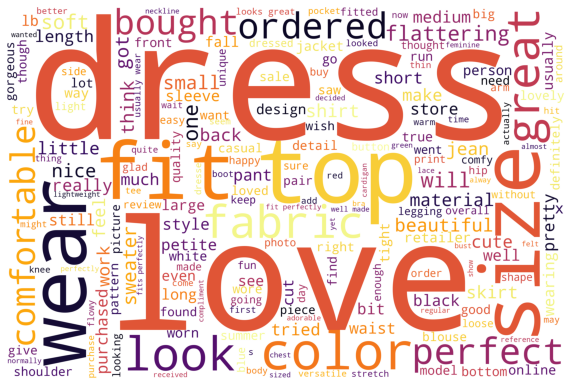

In [46]:
# wordcloud (positive sentiments)
all_words = ' '.join(total_words)                                    
wordcloud = WordCloud(stopwords=STOPWORDS,                         
                      width=3000, height=2000,
                      background_color='white',
                      colormap='inferno')

wordcloud.generate(all_words)                                    

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**For Negative Sentiments**

In [47]:
# positive sentiments data
ndata = frame[frame['label']=='negative']['feature']

In [48]:
# index reset
ndata.reset_index(drop=True,inplace=True)

In [49]:
# gathering all words
total_words = []

for i in range(len(ndata)):
    total_words.extend(ndata[i])

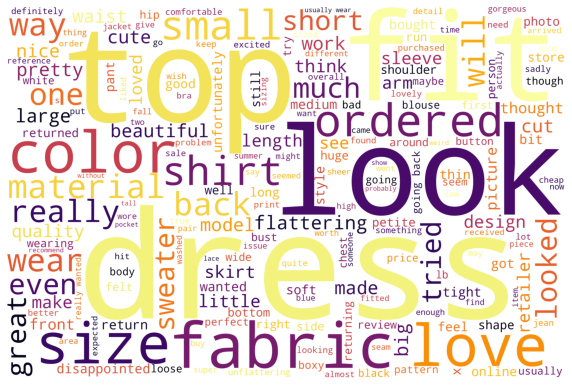

In [50]:
# wordcloud (negative sentiments)
all_words = ' '.join(total_words)                                    
wordcloud = WordCloud(stopwords=STOPWORDS,                         
                      width=3000, height=2000,
                      background_color='white',
                      colormap='inferno')

wordcloud.generate(all_words)                                    

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Word and Document Features

In [51]:
# deciding the document features
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [52]:
# creating the featuresets
featuresets = [(document_features(feature), label) for index, (feature, label) in frame.iterrows()]

In [53]:
# checking a featureset of 5th review
featuresets[5]

({'contains(dress)': False,
  'contains(love)': False,
  'contains(size)': False,
  'contains(top)': False,
  'contains(fit)': False,
  'contains(like)': True,
  'contains(wear)': False,
  'contains(great)': False,
  'contains(would)': False,
  'contains(fabric)': True,
  'contains(color)': False,
  'contains(small)': False,
  'contains(look)': True,
  'contains(really)': False,
  'contains(ordered)': False,
  'contains(little)': True,
  'contains(perfect)': False,
  'contains(one)': True,
  'contains(flattering)': False,
  'contains(soft)': False,
  'contains(well)': False,
  'contains(back)': False,
  'contains(comfortable)': False,
  'contains(cute)': False,
  'contains(nice)': False,
  'contains(bought)': False,
  'contains(beautiful)': False,
  'contains(bit)': True,
  'contains(looks)': False,
  'contains(fits)': False,
  'contains(0)': False,
  'contains(large)': False,
  'contains(material)': False,
  'contains(much)': False,
  'contains(length)': False,
  'contains(also)': Tru

In [54]:
# training the naive bayes classifier

tr_data = featuresets[0:int(len(featuresets)*0.7)] 
ts_data = featuresets[int(len(featuresets)*0.7):]

classifier = nltk.NaiveBayesClassifier.train(tr_data)

In [55]:
# model validation

score = nltk.classify.accuracy(classifier, ts_data)
print('Model Accuracy: {}'.format(round(score,4)))

Model Accuracy: 0.8669


------------

### Approach-02 

Using ML Naive Bayes Classifier.

### TF-IDF Vectorizer

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [58]:
print(data.head())

                                              review     label
0  beautiful and very versatile dress extremely f...  positive
1  i do not have anything like it in my closet re...  positive
2  this is a cute dress but the buttons are tiny ...  negative
3  i bought this shirt at the store and after goi...  positive
4  i love the paisley print very soft and comfy f...  positive


In [59]:
# we need features and labels
features = data['review'].values
label = data['label']

In [60]:
# using tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=5000, min_df=0.05, max_df=0.8)
vectorized_features = vectorizer.fit_transform(features).toarray()

In [61]:
# vectorized reviews
pd.DataFrame(vectorized_features, columns=vectorizer.get_feature_names()).head(10).iloc[:,:15]

,about,all,also,am,an,are,as,at,back,be,beautiful,because,been,better,big
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.642846,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.127398,0.196076,0.152183,0.000000,0.000000,0.0,0.153007,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.183706,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.0,0.134522,0.137780,0.000000,0.000000,0.000000,0.108069,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,0.0,0.000000,0.143851,0.086483,0.000000,0.000000,0.112832,0.240953,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
7,0.0,0.000000,0.000000,0.000000,0.000000,0.185015,0.000000,0.000000,0.0,0.000000,0.000000,0.243925,0.0,0.0,0.0
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
9,0.0,0.000000,0.000000,0.125642,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [62]:
# train, test splits
x_train, x_test, y_train, y_test = train_test_split(vectorized_features, label, test_size=0.3, random_state=0)

In [63]:
# training and testing data scores
model = GaussianNB().fit(x_train,y_train)

tr_score = model.score(x_train,y_train)
ts_score = model.score(x_test,y_test)

print('Accuracy Score for Training Data : {}'.format(round(tr_score,4)))
print('Accuracy Score for Testing Data  : {}'.format(round(ts_score,4)))

Accuracy Score for Training Data : 0.7599
Accuracy Score for Testing Data  : 0.7522


In [64]:
# for overall dataset
model = GaussianNB().fit(vectorized_features,label)
score = np.round(model.score(vectorized_features,label),4)

print('Accuracy of Naive Nayes Model: {}'.format(score))

Accuracy of Naive Nayes Model: 0.7574


----------